In [24]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from statsmodels.tsa.seasonal import STL
import logging
from data_stream import *

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(message)s')

Amp = 10
T = 200
# Define the trend, seasonality, and noise functions
def trend(t):
    return Amp*np.log(1+(Amp/T * t)) 
        
    

def seasonality(t):
    return Amp * np.sin(2 * np.pi * t / T)  # Seasonal cycle

def noise(size):
    return np.random.normal(0, 0.1*Amp, size)  # Random noise with mean 0 and standard deviation 2

# Function to generate a data point with trend, seasonality, and noise
def generate_data_points(num):
    t = np.arange(num)
    return trend(t) + seasonality(t) + noise(num)

# Function to generate a data points with p = 0.1 anomalies
def generate_data_point_with_anomalies(num,p):
    data_points = generate_data_points(num)
    # create the anomalies 
    anomalies_num = int(p*num)
    anomalies_values = 1.5*Amp 
    anomalies_indices = np.random.permutation(np.arange(200,num))[:anomalies_num]
    data_points[anomalies_indices] += anomalies_values * (((data_points[anomalies_indices] - data_points[anomalies_indices-1])>=0)*2-1)
    
    
    return data_points, anomalies_indices


def stl_zscore_anomaly_detection(data_stream, window_size=1000, z_threshold=3):
    """
    Detects anomalies in a data stream using STL decomposition and Z-Score.

    Parameters:
    - data_stream: list or iterable of incoming data points (float values).
    - window_size: int, the number of most recent data points to use for each STL decomposition.
    - seasonal_period: int, estimated period for seasonality (e.g., 12 for monthly data if the data is daily).
    - z_threshold: float, Z-Score threshold for flagging anomalies.

    Returns:
    - anomalies: list of tuples (index, value) where anomalies were detected.
    """
    # Store data points and anomalies
    data_window = []
    # Initialize the anomaly indices
    anomaly_indices = []
    # Initialize the anomaly scores
    anomaly_scores = []
    # Initialize the anomaly count
    anomaly_count = 0
    # Initialize the date indexes
    date_indexes = pd.date_range(start='1/1/2020', periods=window_size, freq='ms')
    
    
    for index, data_point in enumerate(data_stream):
        # Append the new data point to the sliding window
        data_window.append(data_point)
        
        # Maintain only the latest `window_size` points in the sliding window
        if len(data_window) > window_size:
            data_window.pop(0)
        
        # Proceed only when the sliding window is full
        if len(data_window) == window_size:
            # Perform STL decomposition
            try:
                df = pd.DataFrame(data_window)
                df.index = date_indexes
                stl = STL(df)
                result = stl.fit()
                residual = result.resid

                # Calculate Z-Score for the residual
                mean_resid = np.mean(residual)
                std_resid = np.std(residual)
                z_scores = (residual - mean_resid) / std_resid
                # Check the most recent data point's Z-Score for anomaly
                if abs(z_scores.iloc[-1]) > z_threshold:
                    data_window.pop()
                    anomaly_count += 1
                    anomaly_indices.append(index)
                    anomaly_scores.append(z_scores.iloc[-1])
                    
            except Exception as e:
                logging.error(f"Error in STL decomposition or Z-Score calculation: {e}")



    return anomaly_indices, anomaly_scores, anomaly_count


    
    



In [25]:
data_points, anomalies_indecies = generate_data_point_with_anomalies(1000,0.01)

In [26]:
predicted_anomalies = stl_zscore_anomaly_detection(data_points, window_size=200, z_threshold=3)

In [27]:
predicted_anomalies

([215, 233, 332, 485, 559, 624, 627, 759, 827, 847],
 [-5.2314611386048195,
  5.184882796569362,
  -5.026124003958702,
  -5.211414824320316,
  -5.775206552325465,
  -4.874772639433068,
  -5.574170786490578,
  -5.089583487505327,
  -4.610033094400042,
  -5.182310889266411],
 10)

In [28]:
count = 0
for i in predicted_anomalies[0]:
    if i in anomalies_indecies:
        count += 1
count,(predicted_anomalies[2]-count)/10000,count/predicted_anomalies[2]

(10, 0.0, 1.0)

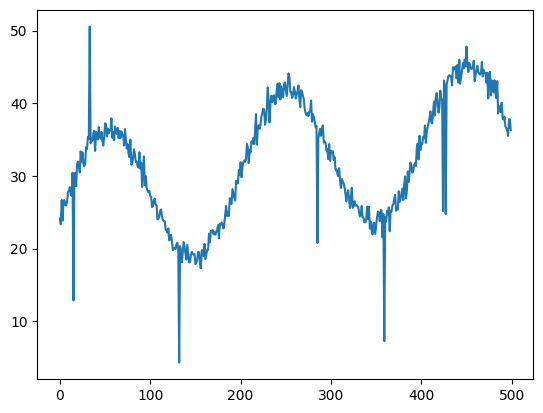

In [29]:
plt.plot(data_points[200:700])

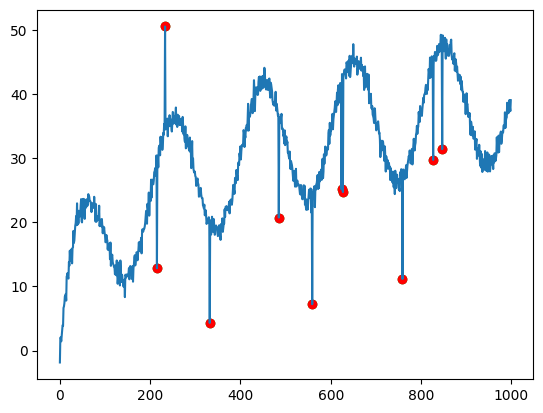

In [30]:
# plot the data points with the anomalies and change color of the anomalies
plt.plot(data_points)
plt.scatter(anomalies_indecies, [data_points[i] for i in anomalies_indecies], color='green')
plt.scatter(predicted_anomalies[0], [data_points[i] for i in predicted_anomalies[0]], color='red')
plt.show()
